In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from math import ceil
import numpy as np
import pickle
import pandas as pd
from IPython.display import Image, clear_output

In [2]:
class Curve:
    def __init__(self, k_T, lambda_1, t=0):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.

    def __repr__(self):
        return f'Curve: {self.a} log(mu) + {self.b} (mu-1), t={self.t}.'

    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)

    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)

    def ymax(self):
        return self.evaluate(self.xmax())

    def xmax(self):
        return -self.a/self.b

    def is_negative(self):
        #returns true if slope at mu=1 is negative (i.e. no evidence for positive change)
        return (self.a + self.b) < 0

    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)

def focus_step(curve_list, k_T, lambda_1):
    new_curve_list = []
    global_max = 0
    time_offset = 0
    if not curve_list: #list is empty

        if k_T <= lambda_1:
            return new_curve_list, global_max, time_offset
        else:
            updated_c = Curve(k_T, lambda_1, t=-1)
            new_curve_list.append(updated_c)
            global_max = updated_c.ymax()
            time_offset = updated_c.t

    else: #list not empty: go through and prune

        updated_c = curve_list[0].update(k_T, lambda_1) #check leftmost quadratic separately
        if updated_c.is_negative(): #our leftmost quadratic is negative i.e. we have no quadratics
            return new_curve_list, global_max, time_offset
        else:
            new_curve_list.append(updated_c)
            if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                global_max = updated_c.ymax()
                time_offset = updated_c.t

            for c in curve_list[1:]+[Curve(0, 0)]:#add on new quadratic to end of list
                updated_c = c.update(k_T, lambda_1)

                if new_curve_list[-1].dominates(updated_c):
                    break #quadratic q and all quadratics to the right of it are pruned out by q's left neighbour
                elif updated_c.is_negative():
                    pass #delete q and move on
                else:
                    new_curve_list.append(updated_c)

                    if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                        global_max = updated_c.ymax()
                        time_offset = updated_c.t



    return new_curve_list, global_max, time_offset

def plot_curves(curve_list, threshold=25, T=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f"FOCuS step at detection time $T={T}$")

    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{T}(\mu)$", rotation=0)

    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)


    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot

    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+T+1}$')

    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

def focus(X, lambda_1, threshold, plot=False):
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)

    signif = []
    offsets = []

    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T])
        signif.append(global_max)
        offsets.append(time_offset)

        if plot:
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.show()

        if global_max > threshold:
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.show()
            return global_max, time_offset+T+1, T, signif, offsets

    return 0, len(X)+1, len(X), signif, offsets #no change found by end of signal

In [3]:
def simple_exponential_smoothing(signal, α):

    output = [signal[0:20].mean()]
    estimate = signal[0:20].mean()

    for point in signal[1:]:
        estimate = α*(estimate) + (1-α)*point
        output.append(estimate)

    return output

def plot_signif(fname):
    with open(f'{fname}', 'rb') as handle:
        d = pickle.load(handle)

    data = pd.DataFrame(index=d[0][:-1])
    data.index.rename("mission elapsed time", inplace=True)

    times = pd.Series(data.index)

    for key in d[1].keys():
        data[key] = d[1][key]

    signal_1 = data.iloc[:, 1] #first detector, 50-300keV
    signal_2 = data.iloc[:, 4] #second detector, 50-300keV

    background_1 = simple_exponential_smoothing(signal_1.values, α=0.97)[:-40]
    background_2 = simple_exponential_smoothing(signal_2.values, α=0.97)[:-40]

    raw_data_1 = signal_1.values[40:]
    raw_data_2 = signal_2.values[40:]

    _, _, _, signif_1, offsets_1 = focus(raw_data_1, background_1, 100, plot=False)
    _, _, _, signif_2, offsets_2 = focus(raw_data_2, background_2, 100, plot=False)

    anomaly_detected_1 = np.argmax(np.array(signif_1))
    anomaly_start_1 = anomaly_detected_1 + offsets_1[anomaly_detected_1]

    anomaly_detected_2 = np.argmax(np.array(signif_2))
    anomaly_start_2 = anomaly_detected_2 + offsets_2[anomaly_detected_2]

    ##Significance plot
    figs, axs = plt.subplots()

    axs.plot(times[40:], np.sqrt(np.array(signif_1)*2), color="C0", label=f"detector {data.columns[1][1]}")
    axs.plot(times[40:], np.sqrt(np.array(signif_2)*2), color="C1", label = f"detector {data.columns[4][1]}")
    axs.axhline(5, color="red")

    plt.ylabel("sigma level")
    plt.xlabel("mission elapsed time")
    plt.title("Significance")
    plt.legend()

    #plt.savefig('plots/' + fname[:-7] + '_sig.png', dpi = 150)
    plt.show()

    ## Data Plot
    bins, counts, met, isodate = d[0], d[1], d[2], d[3]

    figd, axd = plt.subplots(2, 1)
    range_keys = [key for key in counts.keys() if '_r1' in key] #only take 50-300keV range

    axd[0].step(bins[:-1], counts[range_keys[0]], where='pre', label=range_keys[0][1], color="C0")
    axd[0].set_ylabel(f'detector {range_keys[0][1]}')
    axd[0].axvline(times[anomaly_start_1+40], color="red")
    axd[0].axvline(times[anomaly_detected_1+40], color="red")

    axd[1].step(bins[:-1], counts[range_keys[1]], where='pre', label=range_keys[1][1], color="C1")
    axd[1].set_ylabel(f'detector {range_keys[1][1]}')
    axd[1].axvline(times[anomaly_start_2+40], color="red")
    axd[1].axvline(times[anomaly_detected_2+40], color="red")

    figd.supylabel('counts')
    figd.supxlabel('mission elapsed time')
    plt.suptitle('Trigger at ISO {} UTC'.format(isodate))

    #figd.savefig('plots/' + fname[:-7] + '_burst.png', dpi = 150)
    plt.show()

    pass

def plot_data(bins, counts, met, isodate):
    fig, ax = plt.subplots(2, 1)
    range_keys = [key for key in counts.keys() if '_r1' in key] #only take 50-300keV range

    ax[0].step(bins[:-1], counts[range_keys[0]], where='pre', label=range_keys[0][1], color="C0")
    ax[0].set_ylabel(f'detector {range_keys[0][1]}')
    ax[0].axvline(times[anomaly_start_1+40], color="red")
    ax[0].axvline(times[anomaly_detected_1+40], color="red")

    ax[1].step(bins[:-1], counts[range_keys[1]], where='pre', label=range_keys[1][1], color="C1")
    ax[1].set_ylabel(f'detector {range_keys[1][1]}')
    ax[1].axvline(times[anomaly_start_2+40], color="red")
    ax[1].axvline(times[anomaly_detected_2+40], color="red")

    fig.supylabel('counts')
    fig.supxlabel('mission elapsed time')
    plt.suptitle('Trigger at ISO {} UTC'.format(isodate))

    #fig.savefig('plots/' + fname[:-7] + '_burst.png', dpi = 150)
    plt.show()

    pass

In [13]:
#fname = '528653157d4320141.pickle'
#fname = '528664172d33464026.pickle'
#fname = '528820438d371897.pickle'
fname = '528910872d3934581.pickle'
#fname = 'grb171004857.pickle'

In [15]:
with open(f'{fname}', 'rb') as handle:
        d = pickle.load(handle)

data = pd.DataFrame(index=d[0][:-1])
data.index.rename("mission elapsed time", inplace=True)
times = pd.Series(data.index)
times
for key in d[1].keys():
    data[key] = d[1][key]

signal_1 = data.iloc[:, 1] #first detector, 50-300keV
signal_2 = data.iloc[:, 4] #second detector, 50-300keV



In [16]:
background_1 = simple_exponential_smoothing(signal_1.values, α=0.97)[:-40]
background_2 = simple_exponential_smoothing(signal_2.values, α=0.97)[:-40]

raw_data_1 = signal_1.values[40:]
raw_data_2 = signal_2.values[40:]

len(raw_data_1)

559

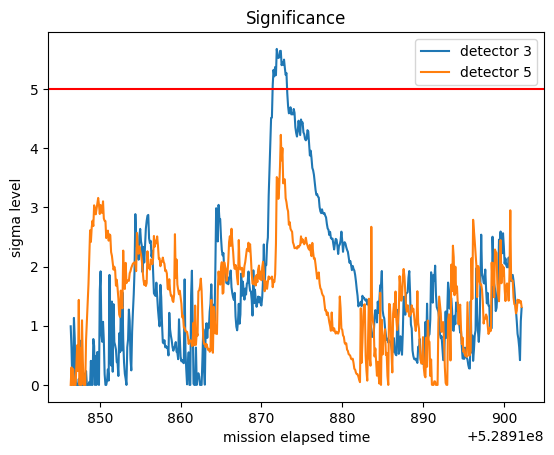

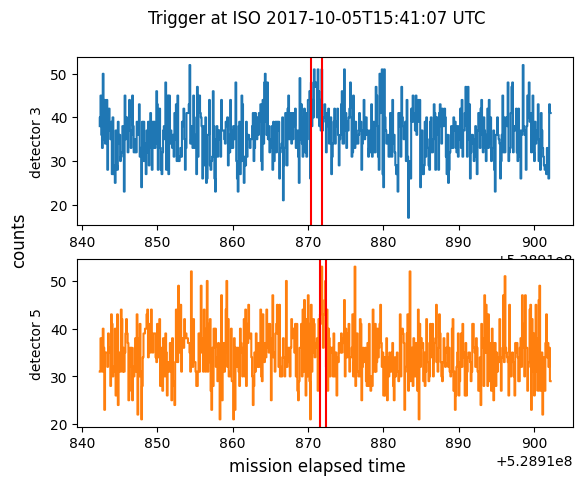

In [17]:
plot_signif(fname)

In [44]:

def e_detector_cusum(data, lambda_vec):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lambda_vec[i], np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lambda_vec[i]) - l + lambda_vec[i]
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lambda_vec[i]) - l + lambda_vec[i]

    return np.apply_along_axis(np.max, 0, E)

def e_detector_sr(data, lambda_vec):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lambda_vec[i], np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = data[i] * np.log(l / lambda_vec[i]) - l + lambda_vec[i]
            else:
                E[j, i] = E[j, i - 1] + data[i] * np.log(l / lambda_vec[i]) - l + lambda_vec[i]

    return np.apply_along_axis(np.sum, 0, E)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


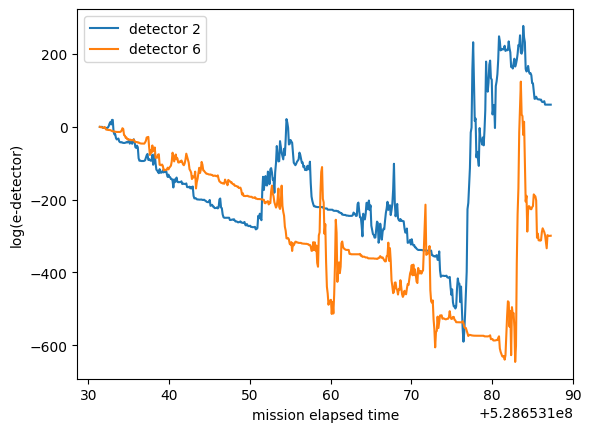

In [57]:
with open(f'{fname}', 'rb') as handle:
  d = pickle.load(handle)

data = pd.DataFrame(index=d[0][:-1])
data.index.rename("mission elapsed time", inplace=True)

times = pd.Series(data.index)

for key in d[1].keys():
  data[key] = d[1][key]

signal_1 = data.iloc[:, 1] #first detector, 50-300keV
signal_2 = data.iloc[:, 4] #second detector, 50-300keV

background_1 = simple_exponential_smoothing(signal_1.values, α=0.97)[:-40]
background_2 = simple_exponential_smoothing(signal_2.values, α=0.97)[:-40]

raw_data_1 = signal_1.values[40:]
raw_data_2 = signal_2.values[40:]

figs, axs = plt.subplots()

axs.plot(times[40:],e_detector_sr(raw_data_1,background_1), color="C0", label=f"detector {data.columns[1][1]}")
axs.plot(times[40:],e_detector_sr(raw_data_2,background_2), color="C1", label=f"detector {data.columns[4][1]}")
plt.ylabel("log(e-detector)")
plt.xlabel("mission elapsed time")
plt.legend()
plt.show()

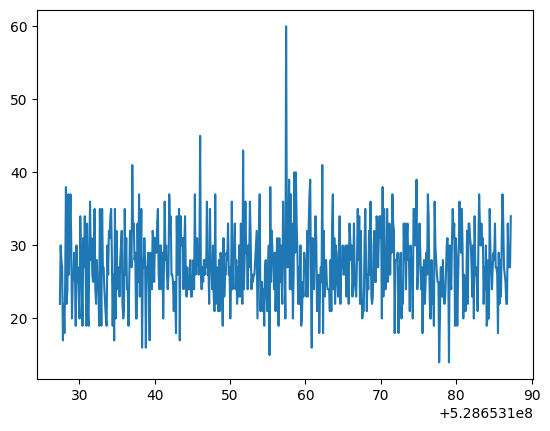

In [50]:
plt.plot(signal_2)
plt.show()